In [1]:
import pandas as pd
import numpy as np
import json
import seaborn
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn
import statsmodels.api as sm
import statsmodels

/Users/shreya/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
otp_by_line = pd.read_json("data/otp_by_line.json")
otp_by_line = otp_by_line.transpose()
otp_by_line[otp_by_line['Peak Service']==''] = np.nan
otp_by_line[otp_by_line['Off-Peak Service']==''] = np.nan
otp_by_line

,Off-Peak Service,Peak Service
1,72.04,71.88
10,63.4,55.87
100,83.85,61.04
101,66.97,65.95
104,55.79,57.16
105,53.53,41.44
106,67.15,62.61
108,65.19,56.12
109,58.77,64.12
11,65.93,70.57


In [33]:
otp_by_line.shape

(198, 2)

In [3]:
# stops = pd.read_csv("data/stops_with_neigborhood.csv")
# stops.head()
stops.to_json("stops.json")
stops.head()

,stop_id,stop_name,parent_station,parent_station_name,stop_lat,stop_lon,city,neighborhood,zip
0,15795,Wonderland West Busway,place-wondl,Wonderland,42.413420,-70.991648,Revere,Revere,2151.0
1,24716,VFW Pkwy opp Wonderland Market Place,NaN,NaN,42.411567,-70.996415,Revere,Revere,2151.0
2,4733,Beach St @ Upham St - Bell Circle,NaN,NaN,42.409697,-71.000379,Revere,Revere,2151.0
3,4526,American Legion Hwy @ Bell Circle,NaN,NaN,42.409969,-71.001815,Revere,Revere,2151.0
4,45261,133 - 135 American Legion Hwy,NaN,NaN,42.412646,-71.002861,Revere,Revere,2151.0


In [35]:
stops.shape

(7768, 9)

# Peak time graph

/Users/pm/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pm/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


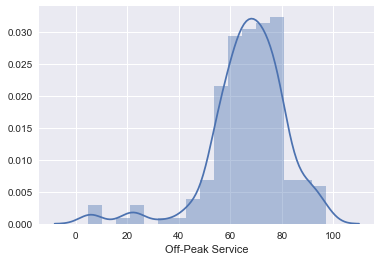

In [45]:
%matplotlib inline
seaborn.distplot(otp_by_line['Off-Peak Service'])

# Non peak time graph

/Users/pm/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pm/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


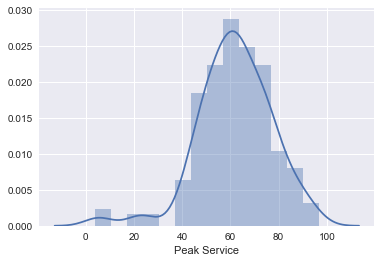

In [46]:
%matplotlib inline
seaborn.distplot(otp_by_line['Peak Service'])

In [48]:
json1_file = open("data/stop_vs_lines.json")
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
stop_by_line = pd.DataFrame([(key, x) for key,val in json1_data.items() for x in val], columns=['Name', 'Values'])
stop_by_line.columns = ['Route','Stop']
stop_by_line  = stop_by_line.set_index('Stop')
stop_by_line.shape

(13719, 1)

In [49]:
stop_by_line.head()

,Route
Stop,
52.62,455
15795,455
24716,455
4733,455
4526,455


In [57]:
stop_route_neighborhood = stop_by_line.join(stops.set_index('stop_id'),how='left')
stop_route_neighborhood = stop_route_neighborhood[stop_route_neighborhood['neighborhood'].notnull()]

In [59]:
stop_route_neighborhood['stop_id'] = stop_route_neighborhood.index
merged = pd.merge(otp_by_line,stop_route_neighborhood, left_index = True, right_on='Route',how='right')
# merged_stop = merged.dropna()
merged_stop = merged[merged['Peak Service'].notnull()]
merged_stop

,Off-Peak Service,Peak Service,Route,stop_name,parent_station,parent_station_name,stop_lat,stop_lon,city,neighborhood,zip,stop_id
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,72.74,74.34,15,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,56.52,57.67,47,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,46.91,46.38,19,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,80.68,56.27,170,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,63.4,55.87,10,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
1,56.29,50.04,8,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,2119.0,1
10,69.06,72.78,9,Theo Glynn Way @ Newmarket Sq,NaN,NaN,42.330555,-71.068787,Boston,Columbia Point,2118.0,10
10,63.4,55.87,10,Theo Glynn Way @ Newmarket Sq,NaN,NaN,42.330555,-71.068787,Boston,Columbia Point,2118.0,10
10,56.29,50.04,8,Theo Glynn Way @ Newmarket Sq,NaN,NaN,42.330555,-71.068787,Boston,Columbia Point,2118.0,10


In [60]:
merged_stop.shape

(12744, 12)

In [86]:
stop_dummy_city = pd.get_dummies(merged_stop['city'])
stop_dummy_city.shape

(12744, 76)

In [87]:
stop_dummy_city.head()

,Allston,Arlington,"Arlington, Town of",Auburndale,Avon,Bedford,Belmont,Beverly,Billerica,Boston,...,Wakefield,Waltham,Watertown,West Newton,West Roxbury,Weymouth,"Weymouth, Town of",Wilmington,Winchester,Woburn
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
stop_dummy_neighborhood = pd.get_dummies(merged_stop['neighborhood'])
stop_dummy_neighborhood.shape

(12744, 179)

In [91]:
stop_dummy_neighborhood.head()

,Agassiz-Harvard University,Allston Village,Allston-Brighton,Angleside,Area IV,Arlington,Arlington Center,Arlington Heights,"Arlington, Town of",Ashmont,...,West Newton,West Roxbury Center,West Somerville,West Street/River Street,Weymouth,"Weymouth, Town of",Wilmington,Winchester,Winter Hill,Woburn
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
merged_dummy_city = merged_stop.join(stop_dummy_city)
merged_dummy_city.shape

(33764, 88)

In [128]:
merged_dummy_city.head()

,Off-Peak Service,Peak Service,Route,stop_name,parent_station,parent_station_name,stop_lat,stop_lon,city,neighborhood,...,Wakefield,Waltham,Watertown,West Newton,West Roxbury,Weymouth,"Weymouth, Town of",Wilmington,Winchester,Woburn
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,...,0,0,0,0,0,0,0,0,0,0
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,...,0,0,0,0,0,0,0,0,0,0
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,...,0,0,0,0,0,0,0,0,0,0
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,...,0,0,0,0,0,0,0,0,0,0
1,72.04,71.88,1,Washington St opp Ruggles St,NaN,NaN,42.330957,-71.082754,Roxbury,Roxbury,...,0,0,0,0,0,0,0,0,0,0


In [131]:
merged_dummy_city_final = merged_dummy_city.groupby('Route').max()
merged_dummy_city_final.shape

(156, 84)

In [133]:
merged_dummy_city_final.head()

,Off-Peak Service,Peak Service,stop_name,stop_lat,stop_lon,neighborhood,zip,stop_id,Allston,Arlington,...,Wakefield,Waltham,Watertown,West Newton,West Roxbury,Weymouth,"Weymouth, Town of",Wilmington,Winchester,Woburn
Route,,,,,,,,,,,,,,,,,,,,,
1,72.04,71.88,Washington St opp Ruggles St,42.375131,-71.073541,South End,2139.0,99,0,0,...,0,0,0,0,0,0,0,0,0,0
10,63.40,55.87,Washington St opp Ruggles St,42.350593,-71.025051,South End,2216.0,9960,0,0,...,0,0,0,0,0,0,0,0,0,0
100,83.85,61.04,Wellington Station Busway,42.436141,-71.075484,Medford,2155.0,9319,0,0,...,0,0,0,0,0,0,0,0,0,0
101,66.97,65.95,Winthrop St @ Woodside Ave,42.428682,-71.066963,Winter Hill,2155.0,9215,0,0,...,0,0,0,0,0,0,0,0,0,0
104,55.79,57.16,Sullivan Station - Upper Busway,42.428682,-71.048315,Malden,2149.0,9215,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
x_cols = merged_dummy_city_final.columns[8:]
y_col = 'Off-Peak Service'

In [141]:
merged_dummy_city_final[y_col].shape

(156,)

In [143]:
merged_dummy_city_final[x_cols].shape

(156, 76)

In [152]:
# http://www.statsmodels.org/dev/glm.html
#http://blog.yhat.com/posts/logistic-regression-and-python.html

model = sm.GLM(merged_dummy_city_final[y_col],merged_dummy_city_final[x_cols], family=sm.families.Gaussian())

results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Off-Peak Service   No. Observations:                  156
Model:                            GLM   Df Residuals:                       89
Model Family:                Gaussian   Df Model:                           66
Link Function:               identity   Scale:                   538.573210815
Method:                          IRLS   Log-Likelihood:                -668.12
Date:                Sat, 11 Nov 2017   Deviance:                       47933.
Time:                        23:37:54   Pearson chi2:                 4.79e+04
No. Iterations:                     2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Allston               -1.7998     15.511     -0.116      0.908     -32.201      28.601
Arlington             -6.099

In [169]:
# This is coefficient, which can be saved in mongodb
results.params

Allston               -1.799848
Arlington             -6.099090
Arlington, Town of    24.285738
Auburndale            14.169082
Avon                  -4.779203
Bedford               -8.200000
Belmont               13.588400
Beverly               26.809622
Billerica             -3.798695
Boston                45.809433
Braintree              0.695249
Brighton               1.175278
Brockton               1.206757
Brookline            -19.598196
Burlington            30.660567
Cambridge             53.957218
Charlestown           11.382592
Chelsea                8.096489
Chestnut Hill         38.432814
Danvers               18.715062
Danvers, Town of      -3.690502
Dedham                 0.903224
Dorchester             4.819218
Dorchester Center     -0.365241
East Weymouth          0.483946
Everett                3.039531
Hanscom AFB            3.870000
Hingham               10.940000
Holbrook               1.206757
Holbrook, Town of      1.206757
                        ...    
Newton C

In [214]:
results.params.index

Index(['Allston', 'Arlington', 'Arlington, Town of', 'Auburndale', 'Avon',
       'Bedford', 'Belmont', 'Beverly', 'Billerica', 'Boston', 'Braintree',
       'Brighton', 'Brockton', 'Brookline', 'Burlington', 'Cambridge',
       'Charlestown', 'Chelsea', 'Chestnut Hill', 'Danvers',
       'Danvers, Town of', 'Dedham', 'Dorchester', 'Dorchester Center',
       'East Weymouth', 'Everett', 'Hanscom AFB', 'Hingham', 'Holbrook',
       'Holbrook, Town of', 'Hyde Park', 'Jamaica Plain', 'Lexington',
       'Lincoln', 'Lynn', 'Lynnfield', 'Malden', 'Marblehead', 'Mattapan',
       'Medford', 'Melrose', 'Milton', 'Nahant', 'Needham', 'Needham Heights',
       'Newton', 'Newton Center', 'Newton Highlands', 'Newton Upper Falls',
       'Newtonville', 'North Weymouth', 'Peabody', 'Quincy', 'Randolph',
       'Reading', 'Revere', 'Roslindale', 'Roxbury', 'Roxbury Crossing',
       'Salem', 'Saugus', 'Somerville', 'South Weymouth', 'Stoneham',
       'Stoneham, Town of', 'Swampscott', 'Wakefield', 

# Preparing data for sample input
# This is a bus route passing through Boston, Cambridge, Arlington, Medford and Woburn

In [216]:
sample_input = np.array([0]*76)
sample_input[list(results.params.index).index('Boston')]=1
sample_input[list(results.params.index).index('Cambridge')]=1
sample_input[list(results.params.index).index('Arlington')]=1
sample_input[list(results.params.index).index('Medford')]=1
sample_input[list(results.params.index).index('Woburn')]=1

sample_input

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1])

In [217]:
results.predict(sample_input)

array([ 74.51756177])